In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.optimize as optimization

In [16]:
stocks = ['AAPL', 'WMT', 'TSLA', 'GE', 'AMZN', 'DB']
start_date = "2021-01-01"
end_date = "2024-01-01"

num_trading_days = 252
num_portfolios = 10000

def show_portfolios(returns, volatilities):
    plt.figure(figsize=(10,6))
    plt.scatter(volatilities, returns, c=returns/volatilities, marker='o')
    plt.grid('True')
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()
    
def download_data():
    stock_data = {}
    for stock in stocks:
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date)['Close']

    return pd.DataFrame(stock_data)

def show_data(df):    
    df.plot(figsize=(10, 5))
    plt.show();

def show_statistics(returns):
    print(returns.mean() * num_trading_days)
    print(returns.cov() * num_trading_days)

def show_mean_covariance(returns, weights):
    portfolio_return = np.sum(returns.mean()*weights) * num_trading_days
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * num_trading_days, weights)))

    print("Expected portfolio mean (return): ", portfolio_return)
    print("Expected portfolio volatility (standard deviation): ", portfolio_volatility)
    
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []
    for _ in range(num_portfolios):
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * num_trading_days)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov() * num_trading_days, w))))

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

def calculate_return(data):
    log_return = np.log(data/data.shift(1))
    return log_return[1:]

In [20]:
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean()*weights) * num_trading_days
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * num_trading_days, weights)))
    return np.array([portfolio_return, portfolio_volatility, portfolio_return/portfolio_volatility])

def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]

def optimize_portfolio(weightrs, returns):
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x)-1}
    bounds = tuple((0, 1) for _ in range(len(stocks))) 
    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns, method='SLSQP', bounds=bounds, 
                         constraints=constraints)

def print_optimal_portfolio(optimal, returns):
    print("Optimal Portfolio: ", optimal['x'].round(3))
    print("Expected return, volatility and Sharpe ratio: ", statistics(optimal['x'].round(3), returns))

def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(10,6))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets/portfolio_vols, marker='o')
    plt.grid('True')
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()

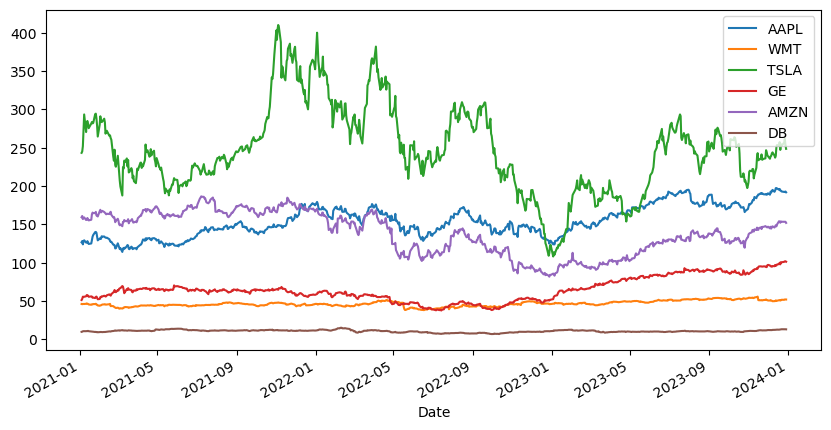

AAPL    0.138993
WMT     0.040099
TSLA    0.007119
GE      0.227631
AMZN   -0.015918
DB      0.095427
dtype: float64
          AAPL       WMT      TSLA        GE      AMZN        DB
AAPL  0.077122  0.016238  0.089435  0.031642  0.063284  0.030759
WMT   0.016238  0.042099  0.017480  0.010281  0.018806  0.009442
TSLA  0.089435  0.017480  0.346714  0.046159  0.101843  0.053227
GE    0.031642  0.010281  0.046159  0.095780  0.037070  0.057328
AMZN  0.063284  0.018806  0.101843  0.037070  0.140007  0.040012
DB    0.030759  0.009442  0.053227  0.057328  0.040012  0.157399


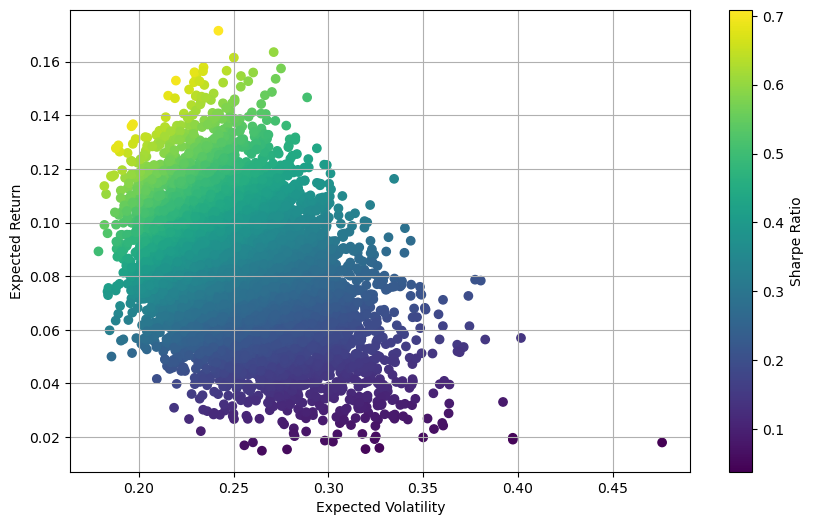

Optimal Portfolio:  [0.304 0.029 0.    0.667 0.    0.   ]
Expected return, volatility and Sharpe ratio:  [0.19524696 0.25157512 0.77609804]


In [21]:
df = download_data()
show_data(df)
log_daily_returns = calculate_return(df)
show_statistics(log_daily_returns)
pweights, means, risks = generate_portfolios(log_daily_returns)
show_portfolios(means, risks)
optimum = optimize_portfolio(pweights, log_daily_returns)
print_optimal_portfolio(optimum, log_daily_returns)